# Ensemble Challenge: Customer Churn Prediction

The challenge of predicting whether a customer will leave the customer portfolio (also known as churn) it's not just a retail problem, being a grouth area on constant study for most industries and service companies that depend on retention.<br>

This is an example type of problem that the scientists from the Luizalabs dive deeply and whose solutions serve to leverage several work fronts. The solution itself brings a lot of value, if it has a high accuracy, it can be used to automatically rank customers with a high risk of churn for an aggressive promotion with the objective of retaining them in the base.<br>

There is also a lot of value in the insights and validation of hypotheses that take place during the process of analyzing the problem and solutions. It can be verified through experimentation that, for example, a customer who buys exclusively on special dates or promotional events has a lower chance of being a churn than one who buys large volumes of the same product.<br>

# Challenge Objectives<br>
This challenge was built in a partnership between <b>Tera</b> and <b>Luizalabs</b>, the main proposal will be to build some solution based on machine learning to predict, if a given Magalu e-commerce customer will continue buying on the platform in 2020 using the customers characteristics and their purchase history in the previous year. At the end, some of these solutions must be combined into an ensemble to create a single solution with the aim of further leveraging results.<br>

In order for the <b>main objective</b> to be accomplished, it will be necessary to build a form of visualization of the created solutions and the comparison with the <b>baseline model</b> and the ensemble model created in the process. The suggested format is a <b>table results</b> the metrics for each model created.<br>

The <b>secondary objective</b> is to raise hypotheses and insights that emerge during the experiments. It is interesting to do this from the beginning as part of EDA, documenting each evidence of new information about the problem. It is also good practice to evaluate trained models, either by exploring their parameters (for example, the weights of a linear model) or using advanced techniques such as [SHAP](https://www.kaggle.com/dansbecker/shap-values), seeking to relate how the features influence the model's responses.<br>

The simplest way to accomplish the <b>secondary objective</b> is to document the analysis and EDA steps in summary form in a report that compiles the main hypotheses and insights. This report can be a text document in the form of a logbook or even a section in this notebook itself where the solution was developed.<br>

## Challenge Score

This challenge also has a <b>score dataset</b>, containing data from customers that are not in the training or test datasets. For these customers, responses <b>(targets)</b> were not available, so it is impossible to verify during solution development whether the model is correct or not.

The purpose of this <b>dataset</b> is to allow students to compare their best solutions with others fairly. Through this [link](https://forms.gle/9Vb4VDVejXLz6wi67) it is possible to send the <b>response file</b> of the challenge. At the end of the challenge, the <b>ranking</b> of student registrations will be shown.

### Let the games begin!!

### Description of Tables and Columns
In this section, the tables and their columns of the challenge will be described. The links to the files and the description of each one are in the following sections. Some code definitions and extractions will already be done at this point, to facilitate the use of the data in the rest of the notebook and to facilitate the explanation of each element.

### Customer Data
Customer data is contained in 3 csv files already separated into training, testing and challenge. This was previously done so that the three datasets had fair distributions of the features of interest, faithfully representing the problem domain.

### Table Columns
The columns for the three files are:

- `client_id:` Globally unique client ID
- `birthdate:` Customer's date of birth
- `state:` State where the customer lives
- `gender:` Gender declared by the client
- `is_churn:` Dependent variable (target) that says whether the customer will churn or not

All columns in the Products Table are symbolic, representing the different categories of the Market Structure tree where the product is inserted.

The names of the subcategories inherit the name of the parent category, so that all the subcategories of the column `category_lv2` that start with "mk38:072" have as their parent category the `category_lv1` named "mk38:072", which in turn is a child of `category_lv0` named "mk38".

An example of categorization:

`category_lv0:` Broader product categories; e.g. "Electronics" or "Fashion"<br>
`category_lv1:` Subcategories; e.g. "Electronics->Notebooks"<br>
`category_lv2:` Sub-subcategories; e.g. "Electronics->Notebooks->UltraThin"<br>
and so on.

The `product_id` column is the global product reference, which can be merged with the sales table.

The columns of this table are described below.

The Entity ID columns are:
- `order_id`: identifier of the sale; may be repeated in other lines, as **each line corresponds to the purchase of a product by a customer**, who may have purchased other products in the same event.
- `client_id`: identifier of the customer who made the purchase
- `datetime`: date and time of purchase
- `units`: quantity of product units that were purchased in this purchase event
- `price`: unit price of the purchased product
- `payment_method`: payment method (credit, debit, _voucher_, etc) for the purchase
- `installments`: number of payment installments; if it is empty, it can be considered that it does not apply
- `delivery_days`: product delivery time
- `delivery_state`: state where the product was delivered; exactly matches the state in the customer tables
- `device`: means where the customer bought; e.g. website, mobile app, shopping terminal
- `source`: _marketing_ channel that generated the _lead_ and caused the customer to buy; for example, it could be a link on a partner page where the customer saw a promotion

### 1 -  Importing the main libraries for the case study

In [1]:
import pandas as pd
import janitor
import numpy as np
import gdown
from datetime import datetime
import shap
import category_encoders as ce
from dython.nominal import associations

import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot
from plotly import tools

from biokit.viz import corrplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score,cross_val_predict, RandomizedSearchCV
from sklearn.metrics import precision_score, plot_roc_curve, make_scorer, f1_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, confusion_matrix
from category_encoders.target_encoder import TargetEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

### 2 - Creating usefull functions

In [2]:
#Table for resume the some initial information from the datasets
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
 

    return summary

In [3]:
#Function to create bargraph using plotly
def plotting_bargraph(df,column_1, column_2, title = None, xlabel_1 = None, xlabel_2 = None, ylabel_1 = None, ylabel_2 = None):
    
    """df1 = Dataframe to be used for plotting
    
       column_1 = The first variable to use in the first graph
       
       column_2 = The second variable to use in the first graph
       
       title = Title of the graph
       
       xlabel_1 = First graph X label axis
       
       xlabel_2 = First graph Y label axis
       
       ylabel_1 = Second graph X label axis
       
       ylabel_2 = Second graph Y label axis
       
       """
    #Defining the subplot
    fig = tools.make_subplots(rows=1, cols=2, print_grid=True, horizontal_spacing=0.1, )

    #Creating Auxiliary datasets
    df_aux_churn = df[df['is_churn'] == False]
    df_aux_nochurn = df[df['is_churn'] == True]

    #First bargraph definitions
    trace1 = go.Bar(x = df_aux_churn[column_1].value_counts().sort_index().index,
                    y = df_aux_churn[column_1].value_counts().sort_index().values,
                    name='Churn (True)',opacity = 0.8, marker=dict(color='seagreen',
                    line=dict(color = '#000000', width = 1)))

    trace2 = go.Bar(x = df_aux_nochurn[column_1].value_counts().sort_index().index,
                    y = df_aux_nochurn[column_1].value_counts().sort_index().values,
                    name='Churn (False)', opacity = 0.8, marker = dict(color='indianred',
                    line = dict(color='#000000', width=1)))

    #Second bargraph definitions
    trace3 = go.Bar(x = df_aux_churn[column_2].value_counts().sort_index().index,
                    y = df_aux_churn[column_2].value_counts().sort_index().values,
                    name='Churn (True)',opacity = 0.8, marker=dict(color='seagreen',
                    line=dict(color = '#000000', width = 1)), showlegend=False)

    trace4 = go.Bar(x = df_aux_nochurn[column_2].value_counts().sort_index().index,
                    y = df_aux_nochurn[column_2].value_counts().sort_index().values,
                    name='Churn (False)', opacity = 0.8, marker = dict(color='indianred',
                    line = dict(color='#000000', width=1)), showlegend=False)

    #Updating X title, Y title and graph title
    fig['layout']['xaxis'].update(title= xlabel_1)
    fig['layout']['yaxis'].update(title= ylabel_1)
    fig['layout']['xaxis2'].update(title= xlabel_2)
    fig['layout']['yaxis2'].update(title= ylabel_2)
    fig['layout']['title'] =  title
    fig['layout']['height'] = 500
    fig['layout']['width'] = 1000


    #Appending the graphs in the subplot
    fig.append_trace(trace1, 1, 1) 
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 2) 
    fig.append_trace(trace4, 1, 2)
    fig.update_layout(legend = dict(y = 1, x = 0.85))
    return iplot(fig)

In [4]:
#Feature to create some features engineering
def create_features_engineering(df, methods, column):
    """df = Should be a datasetylou want to create new features
    methods = It is necessary to pass a list of mathods to create the features
    column = The name of the column that will be used for grouping """
    aux_df = pd.DataFrame()
    for method in methods:
        
        if type(method) == float:  
            aux_df_1 = df.groupby(column).quantile(method).drop(columns='datetime', axis =1)
            aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
            if aux_df.shape[0] == 0:
                aux_df = aux_df_1
            else:
                aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
        elif type(method) == str:
            if method == 'mean':
                aux_df_1 = df.groupby(column).mean()
                aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
                if aux_df.shape[0] == 0:
                    aux_df = aux_df_1
                else:
                    aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
            
            elif method == 'max':
                aux_df_1 = df.groupby(column).max()
                aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
                if aux_df.shape[0] == 0:
                    aux_df = aux_df_1
                else:
                    aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
            
            elif method == 'min':
                aux_df_1 = df.groupby(column).min()
                aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
                if aux_df.shape[0] == 0:
                    aux_df = aux_df_1
                else:
                    aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
            
            elif method == 'std':
                aux_df_1 = df.groupby(column).std()
                aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
                if aux_df.shape[0] == 0:
                    aux_df = aux_df_1
                else:
                    aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
            
            else:
                return (f'Method {method} Not Found')
        else:
            return (f'Method {method} Not Found')
    return aux_df

In [5]:
#Function to encode the datetime features
def encode_data_variables(df, column, max_val):
    data = pd.DataFrame()

    if (max_val == 30) and (column == 'datetime'):
        data['buy_month_sin'] = np.sin(2 * np.pi * df[column].astype('int64')/max_val)
        data['buy_month_cos'] = np.cos(2 * np.pi * df[column].astype('int64')/max_val)
    elif (max_val == 24) and (column == 'datetime'):
        data['buy_hour_sin'] = np.sin(2 * np.pi * df[column].astype('int64')/max_val)
        data['buy_hour_cos'] = np.cos(2 * np.pi * df[column].astype('int64')/max_val)
    elif (max_val == 7) and (column == 'datetime'):
        data['buy_day_sin'] = np.sin(2 * np.pi * df[column].astype('int64')/max_val)
        data['buy_day_cos'] = np.cos(2 * np.pi * df[column].astype('int64')/max_val)
    elif (max_val == 365) and (column == 'datetime'):
        data['buy_year_sin'] = np.sin(2 * np.pi * df[column].astype('int64')/max_val)
        data['buy_year_cos'] = np.cos(2 * np.pi * df[column].astype('int64')/max_val)
    return data

In [6]:
#Features to calculate scores
def compute_score(X, y, model, classifier):
    y_pred = model.predict(X)
    scores = [accuracy_score(y, y_pred),
              precision_score(y, y_pred),
              recall_score(y, y_pred),
              f1_score(y, y_pred)]
    score_results = pd.DataFrame(scores,
                                 columns = [classifier],
                                 index = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).round(3)
    return score_results

### 3 - Creating, downloading and importing the datas the "/data" folder

In [7]:
%%bash
if [  -d "data" ]
then 
    echo "folder 'data' already created, do nothing" 
else
    mkdir data
    echo "created 'data' folder"
fi

folder 'data' already created, do nothing


In [8]:
FILE_INFO = {
    'client_tr': {
        'url':      'https://drive.google.com/uc?id=1GaDgzqFJz-ATMU5ePDD7BPjpSjzZ7kQm',
        'output':   'data/client.train.csv'
    },
    'client_te': {
        'url':      'https://drive.google.com/uc?id=1Pg6AIpM-krtf1aNS3IKUSkoHhun_OxKw',
        'output':   'data/client.test.csv'
    },
    'client_ch': {
        'url':      'https://drive.google.com/uc?id=1JBo7SlIuzmkQgRg9VytkNgXLhZyKmPJV',
        'output':   'data/client.challenge.csv'
    },
    'orders': {
        'url':      'https://drive.google.com/uc?id=1sk7p66kMAu4ZfAUmYVH0YF-cx2kHd4UZ',
        'output':   'data/orders.csv'
    },
    'product': {
        'url':      'https://drive.google.com/uc?id=1wU65H2mwrdd8BhVM8hITCB9sfRVNHFwQ',
        'output':   'data/product.csv'
    }
}

In [9]:
key1 = 'client_tr'
key2 = 'client_te'
key3 = 'client_ch'
key4 = 'product'
key5 = 'orders'

In [10]:
gdown.download(**FILE_INFO[key1], quiet=0)
gdown.download(**FILE_INFO[key2], quiet=0)
gdown.download(**FILE_INFO[key3], quiet=0)
gdown.download(**FILE_INFO[key4], quiet=0)
gdown.download(**FILE_INFO[key5], quiet=0)

Downloading...
From: https://drive.google.com/uc?id=1GaDgzqFJz-ATMU5ePDD7BPjpSjzZ7kQm
To: C:\Users\eoliv\projetos python\Tera\Python\11 - Desafio de Ensemble\data\client.train.csv
100%|███████████████████████████████████████████████████████████████████████████████| 788k/788k [00:00<00:00, 2.33MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pg6AIpM-krtf1aNS3IKUSkoHhun_OxKw
To: C:\Users\eoliv\projetos python\Tera\Python\11 - Desafio de Ensemble\data\client.test.csv
100%|████████████████████████████████████████████████████████████████████████████████| 263k/263k [00:00<00:00, 673kB/s]
Downloading...
From: https://drive.google.com/uc?id=1JBo7SlIuzmkQgRg9VytkNgXLhZyKmPJV
To: C:\Users\eoliv\projetos python\Tera\Python\11 - Desafio de Ensemble\data\client.challenge.csv
100%|████████████████████████████████████████████████████████████████████████████████| 217k/217k [00:00<00:00, 791kB/s]
Downloading...
From: https://drive.google.com/uc?id=1wU65H2mwrdd8BhVM8hITCB9sfRVNHFwQ
To: C:\User

'data/orders.csv'

In [11]:
clients_tr = pd.read_csv(
    FILE_INFO[key1]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
clients_te = pd.read_csv(
    FILE_INFO[key2]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
clients_ch = pd.read_csv(
    FILE_INFO[key3]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
product = pd.read_csv(
    FILE_INFO[key4]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8'
)
orders = pd.read_csv(
    FILE_INFO[key5]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['datetime']
)
display (clients_ch.head(2), clients_te.head(2), clients_tr.head(2))
display (product.head(2), orders.head(2))

birthdate state gender
client_id                        
cx12525   1932-04-19  st15    cg1
cx32280   1983-03-01  st15    cg1

birthdate state gender  is_churn
client_id                                  
cx06840   1982-12-03  st15    cg1     False
cx01931   1979-05-09  st15    cg1     False

birthdate state gender  is_churn
client_id                                  
cx05072   1972-03-22  st25    cg2     False
cx03836   1966-08-14  st15    cg1     False

category_lv0 category_lv1  category_lv2      category_lv3  \
product_id                                                             
px01237            mk38     mk38:072  mk38:072:149  mk38:072:149:218   
px11510            mk38     mk38:072  mk38:072:149  mk38:072:149:218   

                      category_lv4  
product_id                          
px01237     mk38:072:149:218:04846  
px11510     mk38:072:149:218:01337

client_id product_id            datetime  units  price  \
order_id                                                          
ox008433   cx05072    px04611 2019-10-07 15:20:00    1.0   49.9   
ox070389   cx05072    px12305 2019-10-11 17:42:00    1.0   69.9   

         payment_method  installments  delivery_days delivery_state device  \
order_id                                                                     
ox008433           pm05           NaN            NaN           st07    dv9   
ox070389           pm05           NaN            NaN           st07    dv9   

         source  
order_id         
ox008433   sc08  
ox070389   sc08

### 4 - EDA

In [12]:
#Whole overview
display(resumetable(clients_tr.reset_index()))
display(resumetable(clients_ch.reset_index()))
display(resumetable(clients_te.reset_index()))
display(resumetable(orders.reset_index()))
display(resumetable(product.reset_index()))

Dataset Shape: (23292, 5)


Name          dtypes  Missing  Uniques          First Value  \
0  client_id          object        0    23292              cx05072   
1  birthdate  datetime64[ns]        0    13046  1972-03-22 00:00:00   
2      state          object        0       27                 st25   
3     gender          object        0        2                  cg2   
4   is_churn            bool        0        2                False   

          Second Value          Third Value  
0              cx03836              cx08472  
1  1966-08-14 00:00:00  1954-08-07 00:00:00  
2                 st15                 st15  
3                  cg1                  cg1  
4                False                False

Dataset Shape: (7765, 4)


Name          dtypes  Missing  Uniques          First Value  \
0  client_id          object        0     7765              cx12525   
1  birthdate  datetime64[ns]        0     6210  1932-04-19 00:00:00   
2      state          object        0       24                 st15   
3     gender          object        0        2                  cg1   

          Second Value          Third Value  
0              cx32280              cx00471  
1  1983-03-01 00:00:00  1964-08-30 00:00:00  
2                 st15                 st15  
3                  cg1                  cg2

Dataset Shape: (7764, 5)


Name          dtypes  Missing  Uniques          First Value  \
0  client_id          object        0     7764              cx06840   
1  birthdate  datetime64[ns]        0     6252  1982-12-03 00:00:00   
2      state          object        0       25                 st15   
3     gender          object        0        2                  cg1   
4   is_churn            bool        0        2                False   

          Second Value          Third Value  
0              cx01931              cx35431  
1  1979-05-09 00:00:00  1965-05-09 00:00:00  
2                 st15                 st15  
3                  cg1                  cg1  
4                False                False

Dataset Shape: (168472, 12)


Name          dtypes  Missing  Uniques          First Value  \
0         order_id          object        0   133209             ox008433   
1        client_id          object        0    38821              cx05072   
2       product_id          object        0    12535              px04611   
3         datetime  datetime64[ns]        0   102263  2019-10-07 15:20:00   
4            units         float64        0     3373                  1.0   
5            price         float64        0    26391                 49.9   
6   payment_method          object        0       14                 pm05   
7     installments         float64   131927       24                  NaN   
8    delivery_days         float64    78830       71                  NaN   
9   delivery_state          object        0       26                 st07   
10          device          object        0        9                  dv9   
11          source          object        0       16                 sc08   

           Second Value          Third Value  
0              ox070389             ox061137  
1               cx05072              cx06840  
2               px12305              px07033  
3   2019-10-11 17:42:00  2019-01-19 13:09:00  
4                   1.0                  1.0  
5                  69.9                 35.9  
6                  pm05                 pm05  
7                   NaN                  NaN  
8                   NaN                  NaN  
9                  st07                 st07  
10                  dv9                  dv9  
11                 sc08                 sc08

Dataset Shape: (12659, 6)


Name  dtypes  Missing  Uniques             First Value  \
0    product_id  object        0    12659                 px01237   
1  category_lv0  object        0       52                    mk38   
2  category_lv1  object        0      296                mk38:072   
3  category_lv2  object        0      893            mk38:072:149   
4  category_lv3  object        0     1218        mk38:072:149:218   
5  category_lv4  object        0    10763  mk38:072:149:218:04846   

             Second Value             Third Value  
0                 px11510                 px03782  
1                    mk38                    mk38  
2                mk38:072                mk38:072  
3            mk38:072:149            mk38:072:019  
4        mk38:072:149:218        mk38:072:019:066  
5  mk38:072:149:218:01337  mk38:072:019:066:02321

In [13]:
#Treating NA values using iterative inputer
imp = IterativeImputer(estimator=RandomForestClassifier(), random_state=333)
array_for_isna = imp.fit_transform(orders[['installments','delivery_days']])
orders[['installments','delivery_days']] = array_for_isna

In [14]:
clients_tr.head()

birthdate state gender  is_churn
client_id                                  
cx05072   1972-03-22  st25    cg2     False
cx03836   1966-08-14  st15    cg1     False
cx08472   1954-08-07  st15    cg1     False
cx12946   1955-11-16  st15    cg1     False
cx19045   1958-10-25  st15    cg2     False

In [15]:
print("Customer Churn:")
print(round(clients_tr['is_churn'].value_counts(normalize=True) * 100,2))

trace0 = go.Bar(x = clients_tr.reset_index().groupby('is_churn')['client_id'].count().index,
                y = clients_tr.reset_index().groupby('is_churn')['client_id'].count().values,
                marker = dict(color = ['seagreen','indianred']))

data = [trace0]
layout = go.Layout(title='Churn Distribution', xaxis=dict(title='Customes Churn'), yaxis=dict(title='Count'))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Customer Churn:
False    81.94
True     18.06
Name: is_churn, dtype: float64


We see 18.06% of the customers which is the amount of churn considering this amount, let's understando in another plots, the what's the impact for this percentage of churn.
- The lost price for 18.06% of churn
- The State of the churn customers
- the gender of the customers
- The age of the customers

### 5 - Creating some features engineerings

In [16]:
orders_grouped_product = product.join(orders.set_index('product_id'))
orders_grouped_product.shape

(168596, 15)

In [17]:
#For creating other plots, let's create auxililiary dataframes and join in clients_tr aind orders, using client id to join
aux_sum_clients_price_and_units = orders_grouped_product.groupby('client_id').min()
aux_df_clients_with_price = clients_tr.join(aux_sum_clients_price_and_units)
aux_df_clients_with_price['age'] = datetime.today().year - aux_df_clients_with_price['birthdate'].dt.year
age_bins = [0,20,30,40,50,60,70,aux_df_clients_with_price.age.max()]
age_labels = ['less-20','20-30','31-40','41-50','51-60','61-70','70-above']
price_bins = [-9000, 0, 1000, 2500, 3500, 5500, aux_df_clients_with_price.price.max()]
price_labels = ['less zero', '0-10000','10001-25000','25001-50000','50001-75000','75001-above']
aux_df_clients_with_price['price_cat'] = pd.cut(aux_df_clients_with_price.price, bins = price_bins, labels = price_labels).astype('object')
aux_df_clients_with_price['age_cat'] = pd.cut(aux_df_clients_with_price.age, bins = age_bins, labels = age_labels).astype('object')

In [18]:
aux_df_clients_with_price.shape

(23292, 21)

In [19]:
final_df = aux_df_clients_with_price
final_df.drop(columns=list(final_df.dtypes[final_df.dtypes == 'datetime64[ns]'].index), inplace=True)

In [20]:
final_df.shape

(23292, 19)

In [21]:
#Using describe to understand the statistical values
final_df.describe()

units         price  installments  delivery_days           age
count  23292.000000  23292.000000  23292.000000   23292.000000  23292.000000
mean       1.009849    108.321502      1.303666       2.886785     45.234415
std        0.492376    755.316973      1.577355       3.390063     13.702858
min        0.000100  -8999.000000      1.000000       0.000000     12.000000
25%        1.000000      5.000000      1.000000       2.000000     35.000000
50%        1.000000     49.000000      1.000000       2.000000     43.000000
75%        1.000000    184.170000      1.000000       2.000000     55.000000
max       30.000000   6119.100000     24.000000      66.000000    122.000000

In [22]:
plotting_bargraph(final_df, 'gender', 'state', 'Churn Rate Distribution by Gender and State ',
                  'Gender', 'State', 'Churn Count', 'Churn Count')
plotting_bargraph(final_df, 'price_cat', 'age_cat', 'Churn Rate Distribution by Price and Age ',
                  'Price', 'Age', 'Churn Count', 'Churn Count')

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]



This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]



Text(0, 0.5, 'Count')

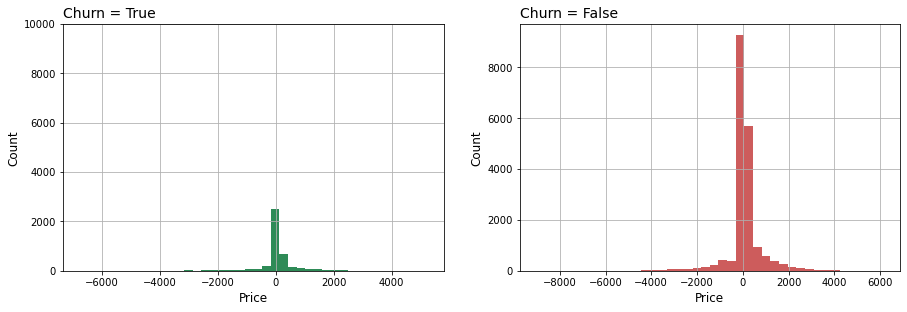

In [23]:
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(221)
ax1= plt.hist(final_df[final_df['is_churn'] == True]['price'], color = 'seagreen', bins = 40)
ax1 = plt.title('Churn = True', fontsize = 14, loc = 'left')
plt.grid(True)
plt.yticks(np.arange(0,11000, 2000))
plt.xlabel('Price', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
fig.add_subplot(222)
ax2 = plt.hist(final_df[final_df['is_churn'] == False]['price'], color = 'indianred', bins = 40)
ax2 = plt.title('Churn = False', fontsize = 14,loc = 'left')
plt.grid(True)
plt.xlabel('Price', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

We have negative prices, this occurs because the return of the purchases. Let's plot a box plot to see in another perspective.

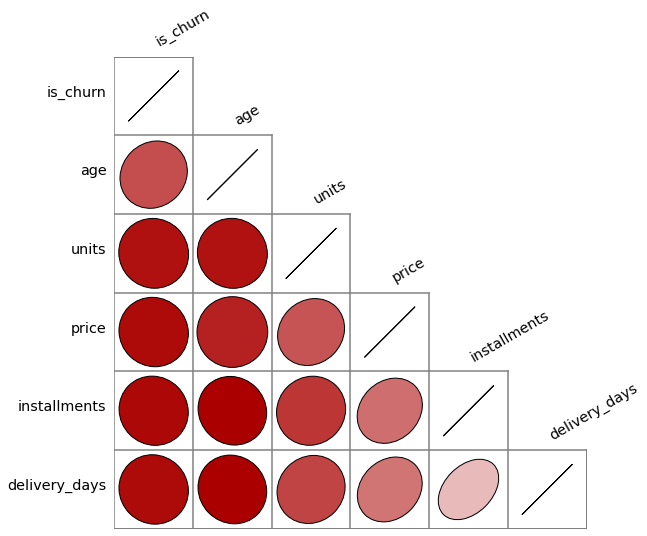

In [24]:
#Creating correlation matrix for numerical features
correlation_matrix = final_df.corr()
correlation_matrix = corrplot.Corrplot(correlation_matrix)
correlation_matrix.plot(colorbar=False, shrink=.9 , lower = 'ellipse', fontsize='x-large')
ax = plt.gcf()
ax.figure.set_size_inches(15,10)

In [25]:
#Creating assosiations matrix for nominal features and numerical features
#First we will create 2 variables, categorical and numerical features
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
nom_corr = associations(dataset = final_df,
                        nominal_columns=categorical_columns,
                        numerical_columns=numerical_columns,
                        figsize=(15,15),
                        cmap ='Blues',
                        plot=False,
                        compute_only=True)

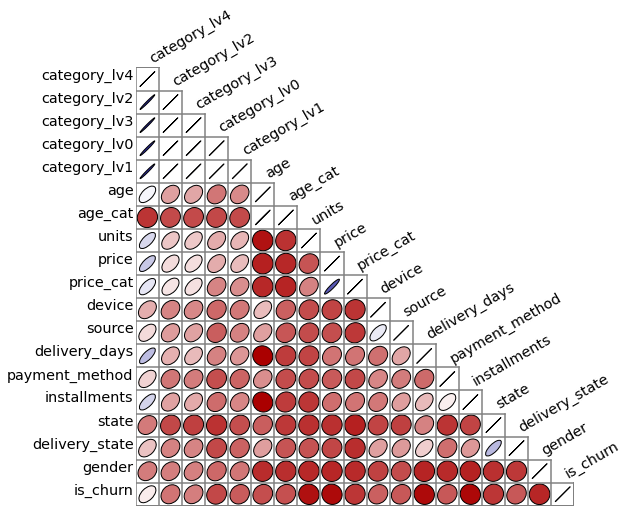

In [26]:
#Ploting Nominal Assotiation
correlation_matrix = nom_corr['corr']
correlation_matrix = corrplot.Corrplot(correlation_matrix)
correlation_matrix.plot(colorbar=False, shrink=.9 , lower = 'ellipse', fontsize='x-large')
ax = plt.gcf()
ax.figure.set_size_inches(15,10)

We see that for the classification the most important features are the features wich is related for the product and its category.

### 6 - Training the baseline model 

#### Preparing the dataset clients_te for predictions and scores

In [27]:
#let's create auxililiary dataframes and join in clients_te and orders, using client id to join
aux_sum_clients_te_price_and_units = orders_grouped_product.groupby('client_id').min()
aux_df_clients_te_with_price = clients_te.join(aux_sum_clients_te_price_and_units)
aux_df_clients_te_with_price['age'] = datetime.today().year - aux_df_clients_te_with_price['birthdate'].dt.year
age_bins = [0,20,30,40,50,60,70,aux_df_clients_te_with_price.age.max()]
age_labels = ['less-20','20-30','31-40','41-50','51-60','61-70','70-above']
price_bins = [-9000, 0, 1000, 2500, 3500, 5500, aux_df_clients_te_with_price.price.max()]
price_labels = ['less zero', '0-10000','10001-25000','25001-50000','50001-75000','75001-above']
aux_df_clients_te_with_price['price_cat'] = pd.cut(aux_df_clients_te_with_price.price, bins = price_bins,
                                                labels = price_labels).astype('object')
aux_df_clients_te_with_price['age_cat'] = pd.cut(aux_df_clients_te_with_price.age,
                                              bins = age_bins, labels = age_labels).astype('object')

In [28]:
final_df_te = aux_df_clients_te_with_price
final_df_te.drop(columns=list(final_df_te.dtypes[final_df_te.dtypes == 'datetime64[ns]'].index), inplace=True)

In [29]:
final_df_te.shape

(7764, 19)

In [30]:
#Let's encode the categorical features
categorical_columns = list(final_df_te.dtypes[final_df_te.dtypes == 'object'].index)
numerical_columns = list(final_df_te.dtypes[final_df_te.dtypes != 'object'].index)
target = TargetEncoder().fit(final_df[categorical_columns], final_df.is_churn)
final_df_te_encoded = final_df_te.copy()
final_df_te_encoded[categorical_columns] = target.transform(final_df_te[categorical_columns])

#Let's transforme the target feature in binary encode
final_df_te_encoded['is_churn'] = final_df_te['is_churn'].map({False:0, True:1})

In [31]:
#Creating X_test and y_test and rescaling
X_te = final_df_te_encoded.drop(columns='is_churn')
y_te = final_df_te_encoded.is_churn
smote = SMOTE()
X_test, y_test = smote.fit_resample(final_df_te_encoded.drop(columns='is_churn'), final_df_te_encoded.is_churn)

#### Preparing the dataset clients_tr 

In [32]:
#Let's prepare the encode for categorical features
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
target = TargetEncoder().fit(final_df[categorical_columns], final_df.is_churn)
final_df_encoded = final_df.copy()
final_df_encoded[categorical_columns] = target.transform(final_df[categorical_columns])

#Let's transforme the target feature in binary encode
final_df_encoded['is_churn'] = final_df['is_churn'].map({False:0, True:1})
final_df_encoded.drop(columns=list(final_df.dtypes[final_df.dtypes == 'datetime64[ns]'].index), inplace=True)

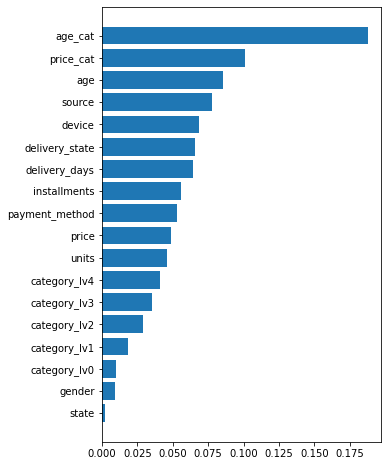

In [33]:
#Creating the model RandomForest for the first evaluation here we are considering just 4 features engineering 
#Age, Age category (spliting the age for groups), sum of price and price category (splitting by groups of prices)
X = final_df_encoded.drop(columns='is_churn')
y = final_df_encoded.is_churn
#We have 18% for churn and 82#forno churn, let's create the simetry between target
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
model_rfc = RandomForestClassifier()
model_rfc.fit(X_smote, y_smote)

coef = model_rfc.feature_importances_
features = X_smote.columns
coef, names = zip(*sorted(zip(coef,features)))
plt.figure(figsize = (5,8))
plt.barh(range(len(features)), coef, align='center')
plt.yticks(range(len(features)), features)
plt.show()

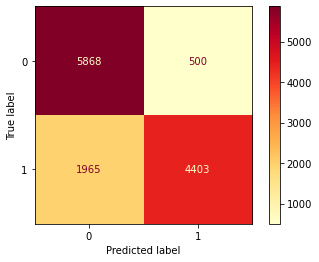

In [34]:
#Plotting confusion matrix
plot_confusion_matrix(model_rfc, X_test, y_test, cmap='YlOrRd', values_format='.0f')

In [35]:
#Printing the score for train e test for comparision
y_pred_train = model_rfc.predict(X_smote)
print('========Train Results========')
print(f'Accuracy: {round(accuracy_score(y_smote, y_pred_train),3)}\n\
Precision: {round(precision_score(y_smote, y_pred_train),3)}\n\
Recall: {round(recall_score(y_smote, y_pred_train),3)}')

y_pred_test = model_rfc.predict(X_test)
print('========Test Results 1========')

print(f'Accuracy: {round(accuracy_score(y_test, y_pred_test),3)}\n\
Precision: {round(precision_score(y_test, y_pred_test),3)}\n\
Recall: {round(recall_score(y_test, y_pred_test),3)}')

========Train Results========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
========Test Results 1========
Accuracy: 0.806
Precision: 0.898
Recall: 0.691


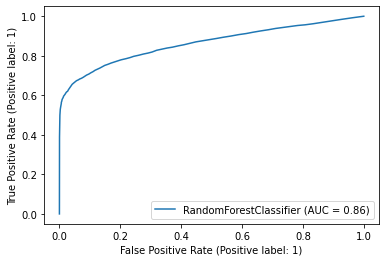

In [36]:
plot_roc_curve(model_rfc, X_test, y_test)

After EDA, feature engineering creation and model trainining, we can conclude that the model didn't have a good performance cosidering all features and is overfitted. we will choose the features based on the feature importance to see the model performance

In [37]:
columns_importance_first_version = list(pd.DataFrame([coef, names]).T.sort_values(0, ascending = False).head(10)[1].values)

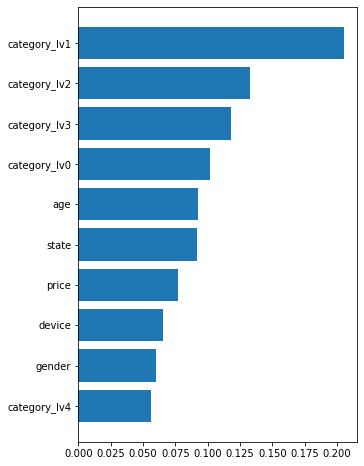

In [38]:
#Creating the model RandomForest for the first evaluation here we are considering just 4 features engineering 
#Age, Age category (spliting the age for groups), sum of price and price category (splitting by groups of prices)
X = final_df_encoded[columns_importance_first_version]
y = final_df_encoded.is_churn
#We have 18% for churn and 82#forno churn, let's create the simetry between target
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
model_rfc = RandomForestClassifier()
model_rfc.fit(X_smote, y_smote)

coef = model_rfc.feature_importances_
features = X_smote.columns
coef, names = zip(*sorted(zip(coef,features)))
plt.figure(figsize = (5,8))
plt.barh(range(len(features)), coef, align='center')
plt.yticks(range(len(features)), features)
plt.show()

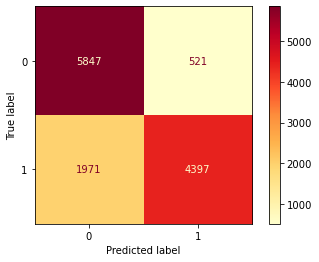

In [39]:
#Plotting confusion matrix
plot_confusion_matrix(model_rfc, X_test[columns_importance_first_version],
                                          y_test, cmap='YlOrRd', values_format='.0f')

In [40]:
#Printing the score for train e test for comparision
y_pred_train = model_rfc.predict(X_smote)
print('========Train Results========')
print(f'Accuracy: {round(accuracy_score(y_smote, y_pred_train),3)}\n\
Precision: {round(precision_score(y_smote, y_pred_train),3)}\n\
Recall: {round(recall_score(y_smote, y_pred_train),3)}')

y_pred_test = model_rfc.predict(X_test[columns_importance_first_version])
print('========Test Results 1========')

print(f'Accuracy: {round(accuracy_score(y_test, y_pred_test),3)}\n\
Precision: {round(precision_score(y_test, y_pred_test),3)}\n\
Recall: {round(recall_score(y_test, y_pred_test),3)}')

========Train Results========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
========Test Results 1========
Accuracy: 0.804
Precision: 0.894
Recall: 0.69


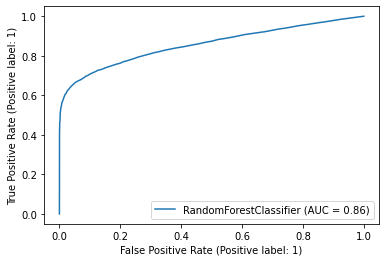

In [41]:
plot_roc_curve(model_rfc, X_test[columns_importance_first_version], y_test)

In spite of the train model is not overfitted, the prediction didn't performed so well, so let's create some features engineering for trying to improve the performance.

### 7 - Creating more features engineerings with create_features_by_product function and encode_data_variables function

In [42]:
#Using the feature engineering function to create addictional features ordered by product_id
orders_with_features_engineerings = create_features_engineering(orders, [0.25,0.50,0.75,0.95,'std', 'mean', 'max', 'min'],
                                                               'client_id')
orders_with_features_engineerings.shape

(38821, 44)

#### Imputing the features in the clients_te

In [43]:
#let's create auxililiary dataframes and join in clients_tr and orders, using client id to join
aux_df_clients_with_price = pd.merge(left=clients_tr, right=orders_with_features_engineerings,
                                     left_index=True, right_index=True)
aux_df_clients_with_price['age'] = datetime.today().year - aux_df_clients_with_price['birthdate'].dt.year
age_bins = [0,20,30,40,50,60,70,aux_df_clients_with_price.age.max()]
age_labels = ['less-20','20-30','31-40','41-50','51-60','61-70','70-above']
aux_df_clients_with_price['age_cat'] = pd.cut(aux_df_clients_with_price.age, bins = age_bins,
                                              labels = age_labels).astype('object')
final_df = aux_df_clients_with_price.copy()

In [44]:
#Treating NA values using simple imputer and most frequent strategy
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
final_df[list(final_df.isnull().mean()[final_df.isnull().mean()!=0].index)] =\
imp.fit_transform(final_df[list(final_df.isnull().mean()[final_df.isnull().mean()!=0].index)])

In [45]:
#Let's going to set the target encoder
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
target = TargetEncoder()
target.fit(final_df[categorical_columns], final_df.is_churn)

TargetEncoder(cols=['state', 'gender', 'product_id_max', 'payment_method_max',
                    'delivery_state_max', 'device_max', 'source_max',
                    'product_id_min', 'payment_method_min',
                    'delivery_state_min', 'device_min', 'source_min',
                    'age_cat'])

#### Imputing the features in the clients_te

In [46]:
#Merging datasets orders with features engineering and product
aux_df_clients_te_with_price = pd.merge(left=clients_te, right=orders_with_features_engineerings,
                                     left_index=True, right_index=True)
aux_df_clients_te_with_price['age'] = datetime.today().year - aux_df_clients_te_with_price['birthdate'].dt.year
age_bins = [0,20,30,40,50,60,70,aux_df_clients_te_with_price.age.max()]
age_labels = ['less-20','20-30','31-40','41-50','51-60','61-70','70-above']
aux_df_clients_te_with_price['age_cat'] = pd.cut(aux_df_clients_te_with_price.age, bins = age_bins,
                                              labels = age_labels).astype('object')
final_df_te = aux_df_clients_te_with_price.copy()

In [47]:
#Treating NA values using simple imputer and most frequent strategy
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
final_df_te[list(final_df_te.isnull().mean()[final_df_te.isnull().mean()!=0].index)] =\
imp.fit_transform(final_df_te[list(final_df_te.isnull().mean()[final_df_te.isnull().mean()!=0].index)])

In [48]:
#Let's encode the categorical features
final_df_te_encoded = final_df_te.copy()
final_df_te_encoded[categorical_columns] = target.transform(final_df_te[categorical_columns])

#Let's transforme the target feature in binary encode
final_df_te_encoded['is_churn'] = final_df_te_encoded['is_churn'].map({False:0, True:1})
final_df_te_encoded.drop(columns=list(final_df_te_encoded.dtypes[final_df_te_encoded.dtypes == 'datetime64[ns]'].index), inplace=True)

In [49]:
#Creating X_test and y_test with features engineering imputed with rescaling
smote = SMOTE()
X_test, y_test = smote.fit_resample(final_df_te_encoded.drop(columns='is_churn'), final_df_te_encoded.is_churn)

#### Imputing the features in the clients_tr

In [50]:
#Using describe to understand the statistical values
final_df.describe()

units_0.25    price_0.25  installments_0.25  delivery_days_0.25  \
count  23292.000000  23292.000000       23292.000000        23292.000000   
mean       1.065392    300.715653           1.452376            3.446376   
std        0.554874    600.939460           1.767241            3.658381   
min        0.027305  -5494.080000           1.000000            0.000000   
25%        1.000000     44.437500           1.000000            2.000000   
50%        1.000000    128.536250           1.000000            2.000000   
75%        1.000000    359.055000           1.000000            3.250000   
max       30.000000   8621.570000          24.000000           66.000000   

          units_0.5     price_0.5  installments_0.5  delivery_days_0.5  \
count  23292.000000  23292.000000      23292.000000       23292.000000   
mean       1.110638    479.138838          1.681629           4.098338   
std        0.680490    630.368459          2.171245           4.286484   
min        0.173870  -4500.000000          1.000000           0.000000   
25%        1.000000     98.900000          1.000000           2.000000   
50%        1.000000    242.405000          1.000000           2.000000   
75%        1.000000    648.056250          1.000000           5.000000   
max       30.000000  13550.890000         24.000000          66.500000   

         units_0.75    price_0.75  ...  delivery_days_mean     units_max  \
count  23292.000000  23292.000000  ...        23292.000000  23292.000000   
mean       1.215316    729.423807  ...            4.485410      1.555083   
std        1.022885    754.600842  ...            4.215516      2.180632   
min        0.428100  -2694.100000  ...            0.000000      1.000000   
25%        1.000000    179.881250  ...            2.000000      1.000000   
50%        1.000000    521.750000  ...            2.705882      1.000000   
75%        1.000000   1012.171250  ...            5.500000      1.000000   
max       60.000000  19270.402500  ...           66.500000    110.000000   

          price_max  installments_max  delivery_days_max     units_min  \
count  23292.000000      23292.000000       23292.000000  23292.000000   
mean    1146.164658          3.016701           7.130603      1.009849   
std     1070.748079          4.084308           7.661478      0.492376   
min        0.000000          1.000000           0.000000      0.000100   
25%      279.900000          1.000000           2.000000      1.000000   
50%      899.000000          1.000000           4.000000      1.000000   
75%     1649.900000          3.000000          10.000000      1.000000   
max    25648.900000         24.000000         165.000000     30.000000   

          price_min  installments_min  delivery_days_min           age  
count  23292.000000      23292.000000       23292.000000  23292.000000  
mean     108.321502          1.303666           2.886785     45.234415  
std      755.316973          1.577355           3.390063     13.702858  
min    -8999.000000          1.000000           0.000000     12.000000  
25%        5.000000          1.000000           2.000000     35.000000  
50%       49.000000          1.000000           2.000000     43.000000  
75%      184.170000          1.000000           2.000000     55.000000  
max     6119.100000         24.000000          66.000000    122.000000  

[8 rows x 33 columns]

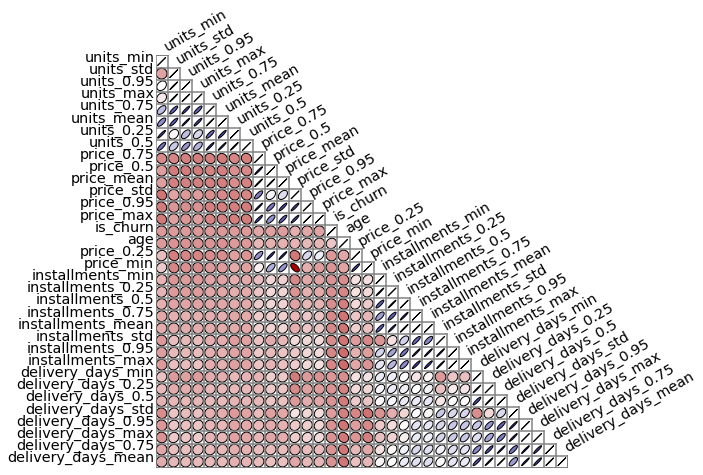

In [51]:
#Creating correlation matrix for numerical features
correlation_matrix = final_df.corr()
correlation_matrix = corrplot.Corrplot(correlation_matrix)
correlation_matrix.plot(colorbar=False, shrink=.9 , lower = 'ellipse', fontsize='x-large')
ax = plt.gcf()
ax.figure.set_size_inches(15,10)

In [52]:
#Creating assosiations matrix for nominal features and numerical features
#First we will create 2 variables, categorical and numerical features
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
nom_corr = associations(dataset = final_df,
                        nominal_columns=categorical_columns,
                        numerical_columns=numerical_columns,
                        figsize=(15,15),
                        cmap ='Blues',
                        plot=False,
                        compute_only=True)

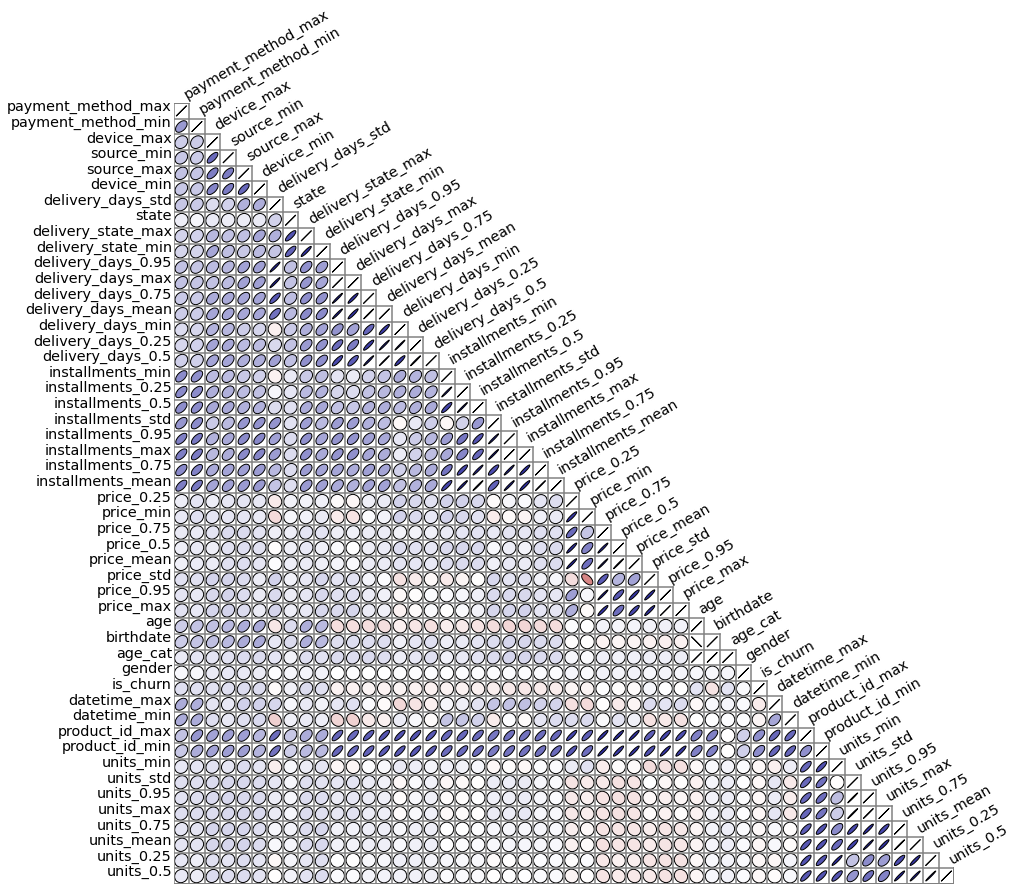

In [53]:
#Ploting Nominal Assotiation
correlation_matrix = nom_corr['corr']
correlation_matrix = corrplot.Corrplot(correlation_matrix)
correlation_matrix.plot(colorbar=False, shrink=.9 , lower = 'ellipse', fontsize='x-large')
ax = plt.gcf()
ax.figure.set_size_inches(20,20)

### 6 - Re-training the baseline model

In [54]:
#Let's encode the categorical features
final_df_encoded = final_df.copy()
final_df_encoded[categorical_columns] = target.transform(final_df[categorical_columns])

#Let's transforme the target feature in binary encode
final_df_encoded['is_churn'] = final_df['is_churn'].map({False:0, True:1})
final_df_encoded.drop(columns=list(final_df.dtypes[final_df.dtypes == 'datetime64[ns]'].index), inplace=True)

In [55]:
#Creating the model RandomForest for the first evaluation here we are considering just 4 features engineering 
#Age, Age category (spliting the age for groups), sum of price and price category (splitting by groups of prices)
X = final_df_encoded.drop(columns='is_churn')
y = final_df_encoded.is_churn

In [56]:
#We have 18% for churn and 82% for no churn, let's create the simetry between target features and the explaners
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

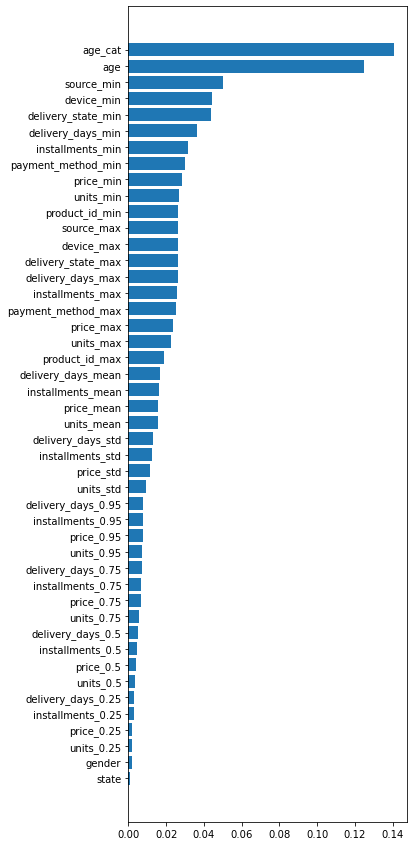

In [57]:
model_rfc_2 = RandomForestClassifier()
model_rfc_2.fit(X_smote, y_smote)
#Predicting the y values
y_pred_rfc_2 = model_rfc_2.predict(X_test)

coef = model_rfc_2.feature_importances_
features = X_test.columns
coef, names = zip(*sorted(zip(coef,features)))
plt.figure(figsize = (5,15))
plt.barh(range(len(features)), coef, align='center')
plt.yticks(range(len(features)), features)
plt.show()

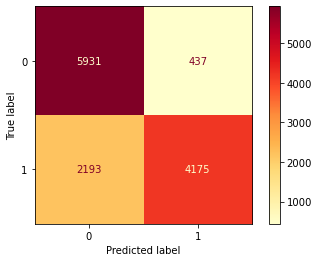

In [58]:
#Plotting confusion matrix
plot_confusion_matrix(model_rfc_2, X_test, y_test, cmap='YlOrRd')

In [59]:
#Printing the score for train e test for comparision
y_pred_train_2 = model_rfc_2.predict(X_smote)
print('========Train Results========')
print(f'Accuracy: {round(accuracy_score(y_smote, y_pred_train_2),3)}\n\
Precision: {round(precision_score(y_smote, y_pred_train_2),3)}\n\
Recall: {round(recall_score(y_smote, y_pred_train_2),3)}')
print('========Test Results 2========')
y_pred_test_2 = model_rfc_2.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, y_pred_test_2),3)}\n\
Precision: {round(precision_score(y_test, y_pred_test_2),3)}\n\
Recall: {round(recall_score(y_test, y_pred_test_2),3)}')

========Train Results========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
========Test Results 2========
Accuracy: 0.793
Precision: 0.905
Recall: 0.656


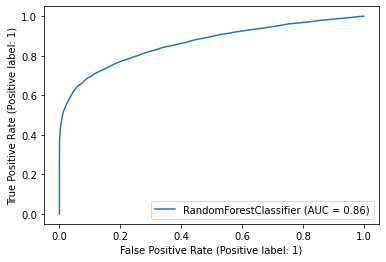

In [60]:
plot_roc_curve(model_rfc_2, X_test, y_test)

We can see the model is overfitted, we are going to try to solve this issue reducing the variables. In general not all variables contribute with the prediction and as consequence they are reduce the test performance.<br>
Let's consider the top 10 features and re-train and test the model to see the performance

In [106]:
columns_importance = list(pd.DataFrame([coef, names]).T.sort_values(0, ascending = False).head(8)[1].values)

In [107]:
model_rfc_2 = RandomForestClassifier()
model_rfc_2.fit(X_smote[columns_importance], y_smote)
#Predicting the y values
y_pred_rfc_2 = model_rfc_2.predict(X_test[columns_importance])

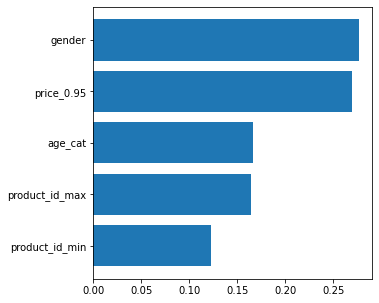

In [108]:
coef = model_rfc_2.feature_importances_
features = X_test[columns_importance].columns
coef, names = zip(*sorted(zip(coef,features)))
plt.figure(figsize = (5,5))
plt.barh(range(len(names)), coef, align='center')
plt.yticks(range(len(features)), features)
plt.show()

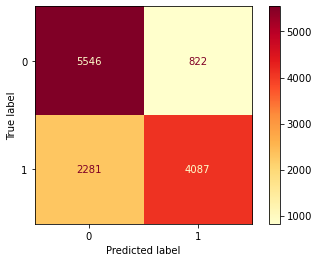

In [109]:
#Plotting confusion matrix
plot_confusion_matrix(model_rfc_2, X_test[columns_importance], y_test, cmap='YlOrRd')

In [110]:
#Printing the score for train e test for comparision
y_pred_train_2 = model_rfc_2.predict(X_smote[columns_importance])
print('========Train Results========')
print(f'Accuracy: {round(accuracy_score(y_smote, y_pred_train_2),3)}\n\
Precision: {round(precision_score(y_smote, y_pred_train_2),3)}\n\
Recall: {round(recall_score(y_smote, y_pred_train_2),3)}')
print('========Test Results 2========')
y_pred_test_2 = model_rfc_2.predict(X_test[columns_importance])
print(f'Accuracy: {round(accuracy_score(y_test, y_pred_test_2),3)}\n\
Precision: {round(precision_score(y_test, y_pred_test_2),3)}\n\
Recall: {round(recall_score(y_test, y_pred_test_2),3)}')

========Train Results========
Accuracy: 0.999
Precision: 0.999
Recall: 0.998
========Test Results 2========
Accuracy: 0.756
Precision: 0.833
Recall: 0.642


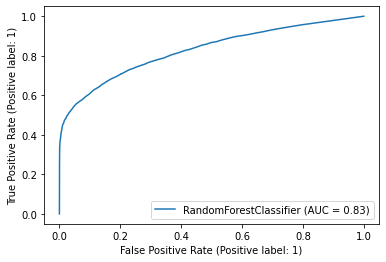

In [111]:
plot_roc_curve(model_rfc_2, X_test[columns_importance], y_test)

In [112]:
#Reporting the results of all
train_score = compute_score(X_smote[columns_importance], y_smote, model_rfc_2, 'Train')

test_score_with_defaut_features = compute_score(X_te[columns_importance_first_version],
                                                y_te, model_rfc, 'Test Default')

test_score_with_features_engineering = compute_score(X_test[columns_importance], y_test, model_rfc_2, 'Test Features')

In [113]:
pd.concat([train_score, test_score_with_defaut_features, test_score_with_features_engineering], axis=1)

Train  Test Default  Test Features
Accuracy   0.999         0.771          0.756
Precision  0.999         0.209          0.833
Recall     0.998         0.099          0.642
F1 Score   0.999         0.134          0.725

As we can see in the dataframe results above, the best performance is the Model with features engineering. Considering that churn models need to have higher recall (False Negative) the better performed for the model is still the model with new features engineering.

<b>For the ensemble challenge we will consider the dataset with features engineering, which we saw having better performance in general, although always pursuing the best Recall performance.

### 7 - Bagging with Decision Tree

In [114]:
tree = DecisionTreeClassifier()
bagging_clf = BaggingClassifier(base_estimator=tree, n_estimators=150, random_state=42, max_features=3, max_samples=5)
bagging_clf.fit(X_smote[columns_importance], y_smote)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=3,
                  max_samples=5, n_estimators=150, random_state=42)

           Bagging
Accuracy     0.560
Precision    0.580
Recall       0.436
F1 Score     0.498


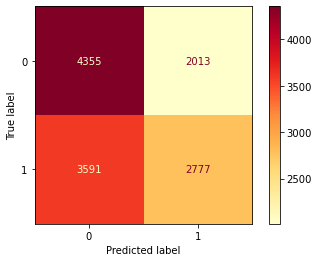

In [115]:
#Reporting the results of all
bagging_score = compute_score(X_test[columns_importance], y_test, bagging_clf, 'Bagging')
print(bagging_score)
plot_confusion_matrix(bagging_clf, X_test[columns_importance], y_test, cmap='YlOrRd')

### 8 - Random Forest Classifier

In [116]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=150)
rf_clf.fit(X_smote[columns_importance], y_smote)

RandomForestClassifier(n_estimators=150, random_state=42)

           Random Forest
Accuracy           0.756
Precision          0.831
Recall             0.642
F1 Score           0.724


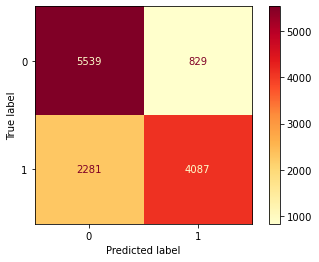

In [117]:
rf_score = compute_score(X_test[columns_importance], y_test, rf_clf, 'Random Forest')
print(rf_score)
plot_confusion_matrix(rf_clf, X_test[columns_importance], y_test, cmap='YlOrRd')

### 9 - ExtraTrees Classifier

In [119]:
ex_tree_clf = ExtraTreesClassifier(n_estimators=150, max_features=3, random_state=42)
ex_tree_clf.fit(X_smote[columns_importance], y_smote)

ExtraTreesClassifier(max_features=3, n_estimators=150, random_state=42)

           ExtraTree
Accuracy       0.758
Precision      0.815
Recall         0.668
F1 Score       0.734


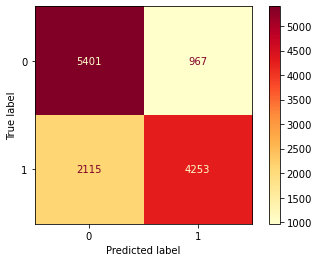

In [120]:
ex_tree_score = compute_score(X_test[columns_importance], y_test, ex_tree_clf, 'ExtraTree')
print(ex_tree_score)
plot_confusion_matrix(ex_tree_clf, X_test[columns_importance], y_test, cmap='YlOrRd')

### 10 - Adaboost Classifier

In [121]:
ada_boost_clf = AdaBoostClassifier(n_estimators=50)
ada_boost_clf.fit(X_smote[columns_importance], y_smote)

AdaBoostClassifier()

           Adaboost
Accuracy      0.729
Precision     0.764
Recall        0.662
F1 Score      0.709


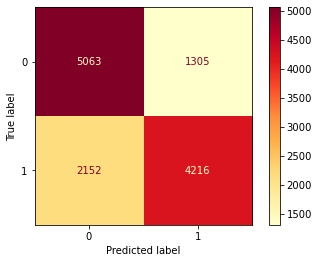

In [122]:
adaboost_score = compute_score(X_test[columns_importance], y_test, ada_boost_clf, 'Adaboost')
print(adaboost_score)
plot_confusion_matrix(ada_boost_clf, X_test[columns_importance], y_test, cmap='YlOrRd')

### 11 - GradientBoosting Classifier

In [123]:
grad_boost_clf = GradientBoostingClassifier(n_estimators=150, random_state=42, learning_rate= 0.4, loss='exponential' )
grad_boost_clf.fit(X_smote[columns_importance], y_smote)

GradientBoostingClassifier(learning_rate=0.4, loss='exponential',
                           n_estimators=150, random_state=42)

           GradientBoost
Accuracy           0.820
Precision          0.900
Recall             0.719
F1 Score           0.799


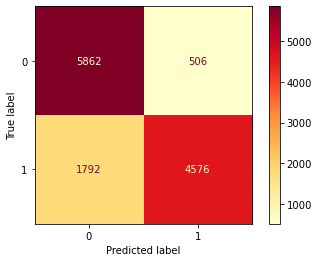

In [124]:
gradient_score = compute_score(X_test[columns_importance], y_test, grad_boost_clf, 'GradientBoost')
print(gradient_score)
plot_confusion_matrix(grad_boost_clf, X_test[columns_importance], y_test, cmap='YlOrRd')

### 13 - Voting Classifier

In [125]:
estimators = []
log_reg = LogisticRegression( solver='liblinear')
estimators.append(('Logistic', log_reg))

tree = DecisionTreeClassifier()
estimators.append(('Tree', tree))

svm_clf = SVC(gamma='scale', probability=True)
estimators.append(('SVM', svm_clf))

voting = VotingClassifier(estimators=estimators, voting='soft')
voting.fit(X_smote[columns_importance], y_smote)

VotingClassifier(estimators=[('Logistic',
                              LogisticRegression(solver='liblinear')),
                             ('Tree', DecisionTreeClassifier()),
                             ('SVM', SVC(probability=True))],
                 voting='soft')

           Voting
Accuracy    0.713
Precision   0.754
Recall      0.631
F1 Score    0.687


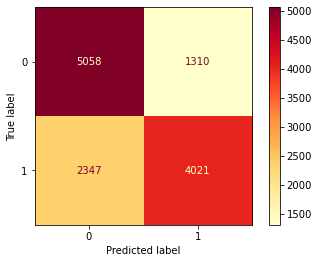

In [126]:
voting_score = compute_score(X_test[columns_importance], y_test, voting, 'Voting')
print(voting_score)
plot_confusion_matrix(voting, X_test[columns_importance], y_test, cmap='YlOrRd')

### 14 - Cross Validation with Xgboost Classifier

In [129]:
xgb_model = XGBClassifier()
xgb_model.fit(X_smote[columns_importance], y_smote)

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)} 
cv = StratifiedKFold(n_splits=10, shuffle=True)

results = cross_validate(estimator = xgb_model,
                            X = X_test[columns_importance],
                            y = y_test,
                           cv = cv,
                      scoring = scoring)

test_score_cv = [results['test_accuracy'].mean(),
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_f1_score'].mean()]

y_pred = cross_val_predict(estimator = xgb_model,
                            X = X_test[columns_importance],
                            y = y_test,
                            cv = cv,)

           Xgboost+CV
Accuracy        0.858
Precision       0.949
Recall          0.756
F1 Score        0.842


<AxesSubplot:>

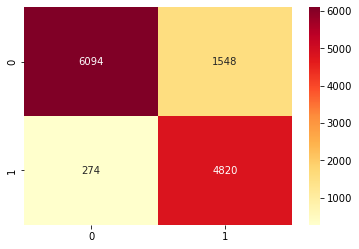

In [130]:
xgboost_score = pd.DataFrame(test_score_cv,
                             index = ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                             columns = ['Xgboost+CV']).round(3)
print(xgboost_score)
sns.heatmap(confusion_matrix(y_pred, y_test), annot = True, fmt='.0f', cmap='YlOrRd')

### 15 - Stacking Classifier

In [131]:
mlp = MLPClassifier(solver='lbfgs', alpha=0.05, max_iter=700, learning_rate='adaptive',
                  random_state=42, hidden_layer_sizes=(50, 40, 5), activation = 'relu')

In [132]:
classifiers = [('xgb', xgb_model),
               ('rfc', rf_clf),
               ('mlp', mlp)]

stacking_model = StackingClassifier(estimators=classifiers, 
                         final_estimator=LogisticRegression(),
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)
stacking_model.fit(X_smote[columns_importance], y_smote)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=0,
                                              gpu_id=-1,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_bin=...


           Stacking
Accuracy      0.777
Precision     0.838
Recall        0.688
F1 Score      0.755


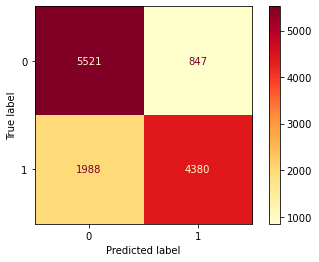

In [134]:
stacking_score = compute_score(X_test[columns_importance], y_test, stacking_model, 'Stacking')
print(stacking_score)
plot_confusion_matrix(stacking_model, X_test[columns_importance], y_test, cmap='YlOrRd')

### 16 - MLP Classifier

In [135]:
mlp.fit(X_smote[columns_importance], y_smote)

MLPClassifier(alpha=0.05, hidden_layer_sizes=(50, 40, 5),
              learning_rate='adaptive', max_iter=700, random_state=42,
              solver='lbfgs')

           MLPClassifier
Accuracy           0.500
Precision          0.500
Recall             0.997
F1 Score           0.666


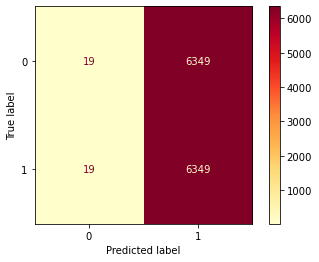

In [136]:
mlp_score = compute_score(X_test[columns_importance], y_test, mlp, 'MLPClassifier')
print(mlp_score)
plot_confusion_matrix(mlp, X_test[columns_importance], y_test, cmap='YlOrRd')

In [137]:
#Concatenating all scores in one table
final_score_results = pd.concat([bagging_score, rf_score, ex_tree_score, adaboost_score, gradient_score,
                                 voting_score, xgboost_score, stacking_score, mlp_score], axis = 1)
final_score_results

Bagging  Random Forest  ExtraTree  Adaboost  GradientBoost  Voting  \
Accuracy     0.560          0.756      0.758     0.729          0.820   0.713   
Precision    0.580          0.831      0.815     0.764          0.900   0.754   
Recall       0.436          0.642      0.668     0.662          0.719   0.631   
F1 Score     0.498          0.724      0.734     0.709          0.799   0.687   

           Xgboost+CV  Stacking  MLPClassifier  
Accuracy        0.858     0.777          0.500  
Precision       0.949     0.838          0.500  
Recall          0.756     0.688          0.997  
F1 Score        0.842     0.755          0.666

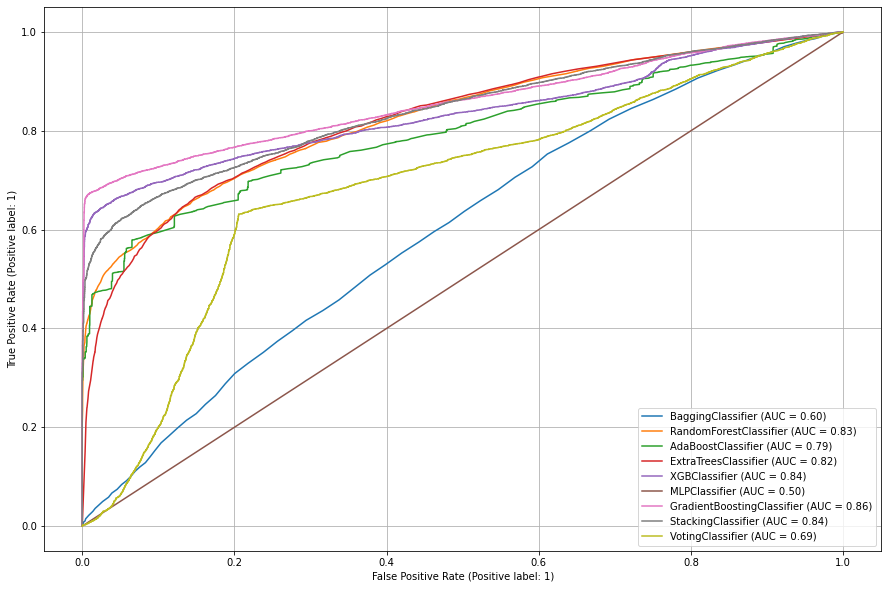

In [139]:
#Ploting all curves ROC
models = [bagging_clf, rf_clf, ada_boost_clf, ex_tree_clf, xgb_model, mlp, grad_boost_clf, stacking_model, voting]

plt.figure(figsize = (15,10))
plt.grid(True)
ax = plt.gca()
for model in models:
    plot_roc_curve(model, X_test[columns_importance], y_test, ax = ax)

Summarizing everything, we have the best performance using Xgboost classifier with cross validation. Considering is a churn analysis, the Recall is the score we need to focus and again Xgboost have the best performance.

Let's try to improve the model finding the best hyperparameters with RandomizedSearch

In [140]:
parameters ={'max_depth':range(3, 19, 2),
        'gamma': range(1,9),
        'reg_alpha' : range(40,180,10),
        'reg_lambda' :[0,1],
        'colsample_bytree' : [0.5,1],
        'min_child_weight' : range(0, 10, 1),
        'n_estimators': [180,200],
        'learning_rate': [0.1, 0.4, 0.6, 0.9]}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=parameters,
    scoring = 'roc_auc',
    n_iter = 10,
    cv = 10,
    verbose=True,
    random_state=42)
random_search.fit(X_smote[columns_importance], y_smote)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_bin=256...
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=

In [142]:
parameters = grid_search.best_params_

In [143]:
#Re-training the XGBoostmodel wuith the best parameters
xgb_model_hyper = XGBClassifier(reg_lambda = parameters['reg_lambda'],
                                reg_alpha = parameters['reg_alpha'],
                                n_estimators = parameters['n_estimators'],
                                min_child_weight = parameters['min_child_weight'],
                                max_depth = parameters['max_depth'],
                                learning_rate = parameters['learning_rate'],
                                gamma = parameters['gamma'],
                                colsample_bytree = parameters['colsample_bytree'])
xgb_model_hyper.fit(X_smote[columns_importance], y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=9,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=50, reg_lambda=0, ...)

In [144]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)} 
cv = StratifiedKFold(n_splits=10, shuffle=True)

results = cross_validate(estimator = xgb_model_hyper,
                            X = X_test[columns_importance],
                            y = y_test,
                           cv = cv,
                      scoring = scoring)

test_score_cv = [results['test_accuracy'].mean(),
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_f1_score'].mean()]

y_pred = cross_val_predict(estimator = xgb_model_hyper,
                            X = X_test[columns_importance],
                            y = y_test,
                            cv = cv,)

           Xgboost+CV_hyper
Accuracy              0.840
Precision             0.968
Recall                0.704
F1 Score              0.815


<AxesSubplot:>

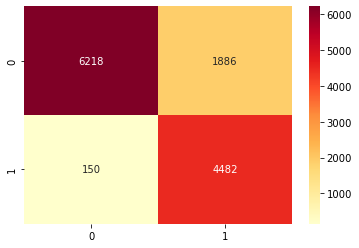

In [145]:
xgboost_score_hyper = pd.DataFrame(test_score_cv,
                             index = ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                             columns = ['Xgboost+CV_hyper']).round(3)
print(xgboost_score_hyper)
sns.heatmap(confusion_matrix(y_pred, y_test), annot = True, fmt='.0f', cmap='YlOrRd')

In [146]:
#Concatenating all scores in one table
final_score_results = pd.concat([bagging_score, rf_score, ex_tree_score, adaboost_score, gradient_score,
                                 voting_score, xgboost_score, stacking_score, xgboost_score_hyper], axis = 1)
final_score_results

Bagging  Random Forest  ExtraTree  Adaboost  GradientBoost  Voting  \
Accuracy     0.560          0.756      0.758     0.729          0.820   0.713   
Precision    0.580          0.831      0.815     0.764          0.900   0.754   
Recall       0.436          0.642      0.668     0.662          0.719   0.631   
F1 Score     0.498          0.724      0.734     0.709          0.799   0.687   

           Xgboost+CV  Stacking  Xgboost+CV_hyper  
Accuracy        0.858     0.777             0.840  
Precision       0.949     0.838             0.968  
Recall          0.756     0.688             0.704  
F1 Score        0.842     0.755             0.815

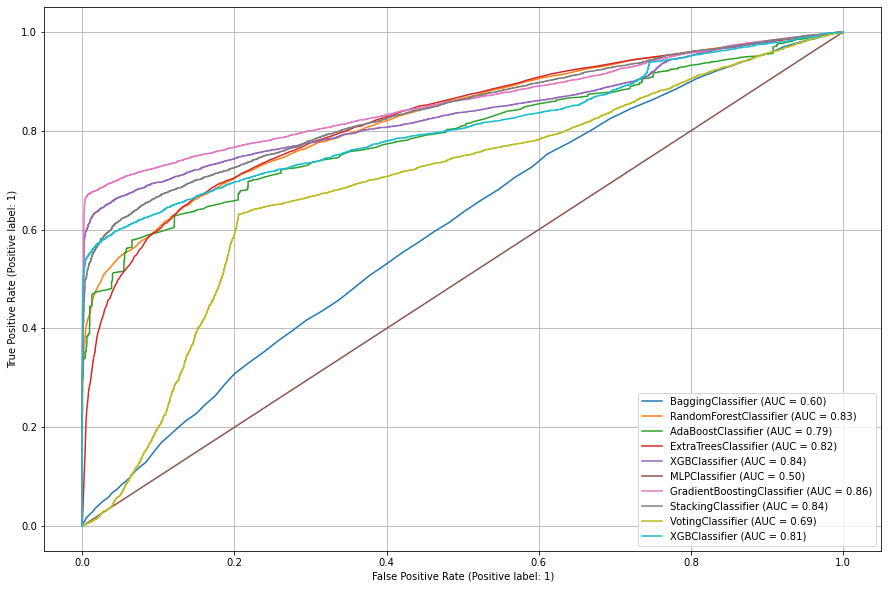

In [147]:
#Ploting all curves ROC
models = [bagging_clf, rf_clf, ada_boost_clf, ex_tree_clf, xgb_model, mlp, grad_boost_clf,
          stacking_model, voting, xgb_model_hyper]

plt.figure(figsize = (15,10))
plt.grid(True)
ax = plt.gca()
for model in models:
    plot_roc_curve(model, X_test[columns_importance], y_test, ax = ax)

In spite of hyperparameters tunning, Xgboost+ cross validation had the best performance thus, we will follow with this model for the challenge prediction

Now le'ts finish the challenge by evaluating the clients_ch results

In [148]:
#let's create auxililiary dataframes and join in clients_ch and orders, using client id to join
aux_df_clients_ch_with_price = pd.merge(left=clients_ch, right=orders_with_features_engineerings,
                                     left_index=True, right_index=True)
aux_df_clients_ch_with_price['age'] = datetime.today().year - aux_df_clients_ch_with_price['birthdate'].dt.year
age_bins = [0,20,30,40,50,60,70,aux_df_clients_ch_with_price.age.max()]
age_labels = ['less-20','20-30','31-40','41-50','51-60','61-70','70-above']
aux_df_clients_ch_with_price['age_cat'] = pd.cut(aux_df_clients_ch_with_price.age, bins = age_bins,
                                              labels = age_labels).astype('object')
final_df_ch = aux_df_clients_ch_with_price.copy()

In [149]:
#Treating NA values using simple imputer and most frequent strategy
final_df_ch[list(final_df_ch.isnull().mean()[final_df_ch.isnull().mean()!=0].index)] =\
imp.fit_transform(final_df_ch[list(final_df_ch.isnull().mean()[final_df_ch.isnull().mean()!=0].index)])

In [150]:
#Let's encode the categorical features
final_df_ch_encoded = final_df_ch.copy()
final_df_ch_encoded[categorical_columns] = target.transform(final_df_ch[categorical_columns])

#Let's transforme the target feature in binary encode
final_df_ch_encoded.drop(columns=list(final_df_ch_encoded.dtypes[final_df_ch_encoded.dtypes == 'datetime64[ns]'].index),
                         inplace=True)
X_ch = final_df_ch_encoded.copy()

In [151]:
submition = pd.DataFrame(xgb_model.predict(X_ch[columns_importance]), index=X_ch.index, columns=['is_churn'])
submition.to_excel("output.xlsx")